# Notebook to work out the data pipeline for Michael's HF PRISM data -> VPL input 

General process from Michael's HF data -> the format needed for VPL:

1. Append prompt and response together with Human: {prompt}\n\nAssistant: {response}. Do this to create both `chosen` and `rejected` fields for the current turn (the preference pair we are trying to predict). 
2. Generate an 'Index' field. This should just be unique to the current row. 
3. Make a dummy `data_subset` called "general" for now. In the VPL work they use the data_subset for various visualizations. If we later do some analysis to cluster various types of prompt-response challenges in the PRISM data we can augment those here for further analysis. 
4. Map the prompt only to `prompt` field. 
5. Map the two responses in order to `responses` field, a List[str]. 
6. If the first response in the `responses` field was the preferred response, set `original_label`: 0 and `label`: 0. Otherwise set both to 1. 
7. Map `objective` to the same thing as `data_subset`. 
8. Set `controversial` to False as a dummy fill-in. I believe in the original paper this was marked for further analysis to emphasize that VPL works better on examples asking controversial/split responses, e.g. comparing cats vs dogs to be better in the pets dataset. The exact definition is left unclear in the OG paper. 
9. Use a similar framework as in `vpl_llm/hidden_context/data_utils/data_processing.generate_embeddings_with_llm()` to generate embeddings for the `chosen` and `rejected` ($s_A$ and $s_B$, respectively, with $[p,r]$ (prompts and responses concatenated). This is essential mapping the `chosen` and `rejected` fields from (1) to a hidden encoded state from the chosen pre-trained LLM (such as GPT2/ llama3). Map these to `embeddings` as a Dict[str, List[float]], where in the dictionary we have keys `embedding_chosen` with value = the LLM embedding of `chosen`, and the same for `embedding_rejected`.)
10. Create a `context_length` which is the length of the NEW FIELD `contexts`. This will NOT match the length of the original `contexts` field in Michael's data, as that is a list of each and every turn (prompt, response, prompt, response, prompt) etc., always ending with the current turn's prompt. Rather, the new contexts field will contain embeddings for previous `embedding_chosen` and `embedding_rejected` for the current user. In the (prompt, response, prompt, response, prompt) example, this means we should expect the NEW `context_length` to be 2, since we will include the two prior $[p,r]$ turn encoding dictionaries. For more details, see (11). 
11. Create a NEW `contexts` field. Each item in the `contexts` field will contain the keys `embedding_chosen`, `embedding_rejected`, and `original_id` (I think this `original_id` is just the row ID of the example used to create `embedding_chosen` and `embedding_rejected`). This is the field to be most careful in creating. + there are some hyperparameters to experiment with here, down the line. For all prior turns in the conversation (1 prior turn minimum, we will opt to NOT predict the first turn, based on other preferences for the same turn as that feels leaky to me (/IS leaky)), we can use ALL 5 choose 2 preference pairs in the dataset and add those to the NEW `contexts` list, or we can just choose the favorite vs. least favorite response (or fav vs. 2nd most fav response) from each prior turn. We can also sample prior turns when there have been many turns to minimize the length and 'soupiness' of the contexts. All of these will affect the learning of the Pair Encoder and Sequential Encoder in the VPL architecture and are thus important choices. So long as we only use embedding pairs from previous (chronologically) turns for the given conversation and user (or from any point in another conversation with this user), then we are not leaking data into the contexts. 

In [20]:
import pandas as pd 
import seaborn as sns
from datasets import load_dataset

In [2]:
dataset = load_dataset('MichaelR207/prism_personalized_1023')

Generating test split: 100%|██████████| 26702/26702 [00:00<00:00, 196706.65 examples/s]


In [3]:
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

In [4]:
train_df.head()

,conversation_id,user_id,context,chosen,rejected,chosen_score,rejected_score,turns,type,dataset,split,flip
0,c2436,user469,[{'content': 'What is your opinion on the curr...,{'content': 'The US-China relationship is curr...,{'content': 'The US-China relationship is comp...,72.0,36.0,1,unguided,prism,train,True
1,c2436,user469,[{'content': 'What is your opinion on the curr...,{'content': 'The US-China relationship is curr...,{'content': '? The US-China relationship is cu...,72.0,62.0,1,unguided,prism,train,True
2,c2436,user469,[{'content': 'What is your opinion on the curr...,{'content': 'The US-China relationship is curr...,{'content': 'I think the US-China relationship...,72.0,21.0,1,unguided,prism,train,False
3,c2436,user469,[{'content': 'What is your opinion on the curr...,{'content': '? The US-China relationship is cu...,{'content': 'The US-China relationship is comp...,62.0,36.0,1,unguided,prism,train,True
4,c2436,user469,[{'content': 'What is your opinion on the curr...,{'content': 'The US-China relationship is comp...,{'content': 'I think the US-China relationship...,36.0,21.0,1,unguided,prism,train,False


<Axes: xlabel='context_length', ylabel='Count'>

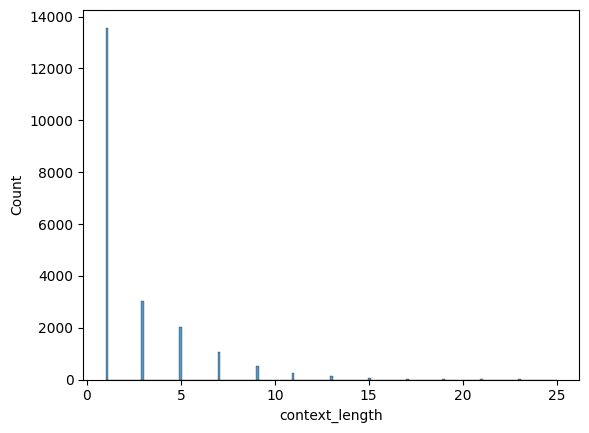

In [27]:
# generate a new column in train_df named context length
train_df['context_length'] = train_df['context'].apply(lambda x: len(x))
sns.histplot(train_df['context_length'])

In [35]:
for idx in range(len(train_df)):
    if train_df.loc[idx, 'context_length'] < 24:
        continue
    print("=======context=========")
    print(f"context length: {len(train_df.loc[idx, 'context'])}")
    for i in range(len(train_df.loc[idx, 'context'])):
        print(train_df.loc[idx, 'context'][i])
    #print(train_df.loc[idx, 'context'])
    print("=========================")

    print("=======chosen=========")
    print(train_df.loc[idx, 'chosen'])
    print("=========================")

    print("=======rejected=========")
    print(train_df.loc[idx, 'rejected'])
    print("=========================")
    print("=======label=========")


=======context=========
context length: 25
{'content': 'On which principles you evaluate a Job Talk in academia?', 'role': 'user'}
{'content': 'Some key principles I evaluate a job talk in academia include: clarity of presentation - is the topic and goals explained clearly? organization - is the content structured in a logical flow? depth of knowledge - does the speaker demonstrate strong command of the subject area? ability to engage audience - through eye contact, gestures, questions? relevance - is the work placed within the context of the field? enthusiasm - does the passion for the topic come through? timing - is the presentation delivered within time constraints?', 'role': 'model'}
{'content': 'How evaluate a bad Job Talk in academia respectfully?', 'role': 'user'}
{'content': 'Here are some respectful ways to evaluate a weaker job talk:\n\nFocus on areas for improvement rather than criticism. Suggest ways to strengthen clarity, organization or depth. Note any disconnects between

In [38]:
import json

# Load JSONL file line-by-line to a DataFrame
with open('./data/simple_pets/gpt2/helpful/test.jsonl', 'r') as file:
    lines = [json.loads(line) for line in file if line.strip()]  # filter out empty lines

pet_df = pd.DataFrame(lines)
pet_df.head()

,chosen,rejected,Index,data_subset,prompt,responses,original_label,objective,label,controversial,embeddings,context_length,contexts
0,Human: Please talk about one kind of pets.\n\n...,Human: Please talk about one kind of pets.\n\n...,0,helpful,Human: Please talk about one kind of pets.,[Birds exhibit complex social behaviors within...,0,helpful,0,False,"{'embedding_chosen': [0.0120239258, 0.09228515...",1,"[{'embedding_chosen': [-0.30078125, -0.1098632..."
1,Human: Please talk about one kind of pets.\n\n...,Human: Please talk about one kind of pets.\n\n...,2,helpful,Human: Please talk about one kind of pets.,"[Dogs have a strong prey drive., Rabbits have ...",1,helpful,0,False,"{'embedding_chosen': [-0.275390625, 0.07324218...",4,"[{'embedding_chosen': [-0.279296875, -0.265625..."
2,Human: Please talk about one kind of pets.\n\n...,Human: Please talk about one kind of pets.\n\n...,4,helpful,Human: Please talk about one kind of pets.,"[Cats can be trained to walk on a leash., Rabb...",1,helpful,0,False,"{'embedding_chosen': [0.0229492188, -0.2128906...",2,"[{'embedding_chosen': [-0.1088867188, 0.160156..."
3,Human: Please talk about one kind of pets.\n\n...,Human: Please talk about one kind of pets.\n\n...,6,helpful,Human: Please talk about one kind of pets.,"[Cats have a natural instinct to bury waste., ...",1,helpful,1,False,"{'embedding_chosen': [-0.0771484375, 0.0126953...",1,"[{'embedding_chosen': [-0.263671875, -0.041992..."
4,Human: Please talk about one kind of pets.\n\n...,Human: Please talk about one kind of pets.\n\n...,10,helpful,Human: Please talk about one kind of pets.,[Birds' feathers provide insulation and aid in...,0,helpful,0,False,"{'embedding_chosen': [-0.0771484375, 0.0126953...",4,"[{'embedding_chosen': [-0.1088867188, 0.160156..."


<Axes: xlabel='context_length', ylabel='Count'>

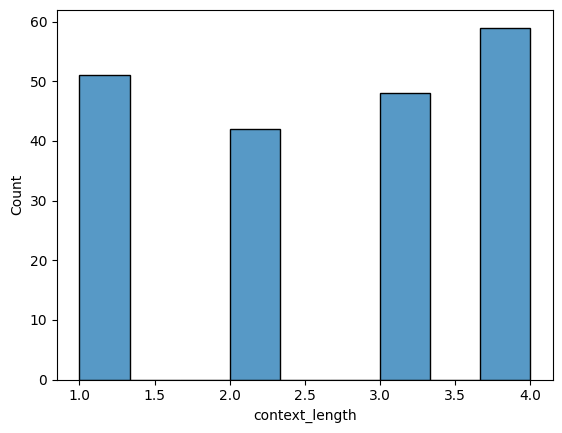

In [40]:
pet_df['context_length'] = pet_df['contexts'].apply(lambda x: len(x))
sns.histplot(pet_df['context_length'])

In [42]:
dict(pet_df.loc[0, 'contexts'][0]).keys()

dict_keys(['embedding_chosen', 'embedding_rejected', 'original_id'])